# **Goal**
The goal of this project is to take the ratings of Movies and their users and to recommend for a random client some Top-N movies. The dataset using is this project are **MovieLens Dataset** from GroupLens Research. The dataset can be found [here](https://grouplens.org/datasets/movielens/).

# Installing and Importing necessary Libraries

In [ ]:
!pip install --upgrade pip
!pip install surprise==0.1

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 11.8 MB 54 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619423 sha256=8963906a84baffe204bd167c99849312d5a57b84c41b74a1b18b43548dfd9c14
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib
from surprise import Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold
%matplotlib inline

# Loading the dataset

In [ ]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


# Exploratory Data Analysis

In [ ]:
type(data)

surprise.dataset.DatasetAutoFolds

In [ ]:
data.raw_ratings[:10]

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596'),
 ('298', '474', 4.0, '884182806'),
 ('115', '265', 2.0, '881171488'),
 ('253', '465', 5.0, '891628467'),
 ('305', '451', 3.0, '886324817'),
 ('6', '86', 3.0, '883603013')]

In [ ]:
# Get the ratings file from the data object
# This is just a filename that has all the data stored in it
ratings_file = data.ratings_file

# Load that table using pandas, a commmon python data loading tool
# We set the column names manually here
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
raw_data = pd.read_table(ratings_file, names=col_names)

In [ ]:
raw_data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
raw_data.shape

(100000, 4)

In [ ]:
raw_data["user_id"].nunique()

943

In [ ]:
raw_data[raw_data["user_id"]==196]

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
940,196,393,4,881251863
1133,196,381,4,881251728
1812,196,251,3,881251274
1896,196,655,5,881251793
2374,196,67,5,881252017
6910,196,306,4,881251021
7517,196,238,4,881251820
7842,196,663,5,881251911
10017,196,111,4,881251793


In [ ]:
raw_data.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

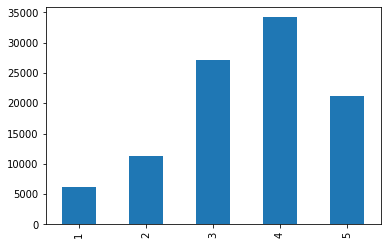

In [ ]:
# 4. Generate a bar plot/histogram of that data
raw_data["rating"].value_counts().sort_index().plot.bar()

Most of the ratings are concentrated on 3, 4 and 5.

In [ ]:
raw_data["rating"].value_counts().sort_index()

1     6110
2    11370
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [ ]:
raw_data["rating"].sum()

352986

# **Modeling**
We have different models that can be considered here for modeling:
- Random model
- User-based model
- Item-based model
- Matrix Factorization Model using Singular Value Decomposition (SVD)

Each of these models have been used and compared to others.

# Random Model

In [ ]:
# Create model object
random_model = NormalPredictor()

In [ ]:
# Train on data using cross-validation with k=5 folds, measuring the RMSE and MAE
model_random_results = cross_validate(random_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5058  1.5245  1.5324  1.5200  1.5231  1.5212  0.0087  
MAE (testset)     1.2047  1.2241  1.2337  1.2218  1.2257  1.2220  0.0095  
Fit time          0.13    0.15    0.16    0.15    0.15    0.15    0.01    
Test time         0.14    0.15    0.16    0.15    0.24    0.17    0.04    


# User-User collaborative filtering

In [ ]:
# Create model object
userBased_model = KNNBasic(sim_options={'user_based': True})

In [ ]:
model_user_results = cross_validate(userBased_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9798  0.9779  0.9827  0.9706  0.9788  0.9780  0.0040  
MAE (testset)     0.7722  0.7727  0.7763  0.7671  0.7724  0.7721  0.0029  
Fit time          0.35    0.47    0.37    0.42    0.43    0.41    0.04    
Test time         3.69    3.80    3.68    3.85    3.75    3.75    0.06    


# Item Item Collaborative Filtering

In [ ]:
# Create model object
itemBased_model = KNNBasic(sim_options={'user_based': False})

In [ ]:
model_item_results = cross_validate(itemBased_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9787  0.9726  0.9775  0.9727  0.9719  0.9747  0.0028  
MAE (testset)     0.7703  0.7695  0.7747  0.7680  0.7674  0.7700  0.0026  
Fit time          0.63    0.64    0.62    0.66    0.66    0.64    0.01    
Test time         4.22    4.37    4.26    4.34    4.21    4.28    0.06    


# Matrix Factorization

In [ ]:
# Create model object
matrix_model = SVD()

In [ ]:
model_matrix_results = cross_validate(matrix_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9308  0.9412  0.9351  0.9303  0.9394  0.9354  0.0044  
MAE (testset)     0.7333  0.7425  0.7390  0.7317  0.7365  0.7366  0.0039  
Fit time          3.94    3.90    3.88    3.89    3.92    3.91    0.02    
Test time         0.31    0.15    0.15    0.27    0.15    0.21    0.07    


# Evaluating the models using **Precision** and **Recall**

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [ ]:
# Make list of k values
K = [5, 10]

# Make list of models
models = [random_model, userBased_model, itemBased_model, matrix_model]
model_names = ['model_random', 'model_user', 'model_item', 'model_matrix']

# Create k-fold cross validation object
kf = KFold(n_splits=5)

for k in K:
    for i, model in enumerate(models):
        print(f'>>> k={k}, model={model_names[i]}')
        # Run folder and take average
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('>>> precision:', round(sum(p) / len(p), 3))
        print('>>> recall  :', round(sum(r) / len(r), 3))
        print('\n')

>>> k=5, model=model_random
>>> precision: 0.585
>>> recall  : 0.344


>>> k=5, model=model_user
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.763
>>> recall  : 0.452


>>> k=5, model=model_item
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.819
>>> recall  : 0.388


>>> k=5, model=model_matrix
>>> precision: 0.783
>>> recall  

# Prediction of Top-N for each user

In [ ]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 5.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [ ]:
for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model name: {model_names[i]}')
    print(f'user ID: {user}')
    print(f'top 5 movie ID\'s this user would like, sorted by rating highest to lowest: \n{top_n[user]}')
    print('\n')

model name: model_random
user ID: 196
top 5 movie ID's this user would like, sorted by rating highest to lowest: 
[('274', 5), ('144', 5), ('16', 5), ('15', 5), ('248', 5)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model name: model_user
user ID: 196
top 5 movie ID's this user would like, sorted by rating highest to lowest: 
[('1189', 5), ('1500', 5), ('814', 5), ('1536', 5), ('1599', 5)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model name: model_item
user ID: 196
top 5 movie ID's this user would like, sorted by rating highest to lowest: 
[('1414', 4.666666666666667), ('1309', 4.5), ('1310', 4.5), ('1675', 4.333333333333333), ('1676', 4.3076923076923075)]
model name: model_matrix
user ID: 196
top 5 movie ID's this user would like, sorted by rating highest to lowest: 
[('169', 4.808033836134141), ('100', 4.788928274770175), ('190', 4.723158083558687), ('316', 4.603664336638125), ('64', 4.559643067216324)]


In [ ]:
top_n

{'1': [('276', 4.832723491939655),
  ('285', 4.706620183277364),
  ('408', 4.674828232356061),
  ('478', 4.664582194550743),
  ('474', 4.6389021028366235)],
 '10': [('169', 4.826960658549494),
  ('114', 4.776990733568244),
  ('408', 4.775635195547667),
  ('963', 4.765394917882806),
  ('313', 4.71476826682047)],
 '100': [('318', 4.434030821066505),
  ('483', 4.386463801478424),
  ('64', 4.343501662523877),
  ('178', 4.327326213646632),
  ('199', 4.260737809846657)],
 '101': [('64', 4.38160742762464),
  ('483', 4.250217436891061),
  ('178', 4.174343544048081),
  ('265', 4.14536480130993),
  ('127', 4.142728131750208)],
 '102': [('318', 3.651481430651335),
  ('408', 3.5953484727682197),
  ('64', 3.5641226364759864),
  ('12', 3.55342349874836),
  ('427', 3.545635957866427)],
 '103': [('408', 4.8279977619942755),
  ('169', 4.640400519542041),
  ('114', 4.464024844400424),
  ('12', 4.388877529522776),
  ('483', 4.387624391793601)],
 '104': [('172', 4.077875473498812),
  ('318', 4.00021734443